In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import scipy
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.precision", 8)


C:\Users\Mumu\AppData\Local\Temp\ipykernel_28552\1089825735.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
merged_data = pd.read_csv(r'C:\Users\Mumu\Desktop\Bonn Econ\RM_applied_micro\GIthub_new\rm-applied-micro\merged_gps_gallup.csv')

C:\Users\Mumu\AppData\Local\Temp\ipykernel_28552\3089198683.py:1: DtypeWarning: Columns (16,63,66,68,69,71,72,75,79,80,81,82,83,84,86,88,90,91,94,96,97,99,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,120,121,125,126,129,131,137,138,139,142,144,147,148,149,154,159,163,165,166,168,170,171,173,174,175,178,184,186,187,188,189,190,191,192,193,194,195,198,200,201,202,203,204,205,206,208,209,210,211,213,214,215,216,218,221,222,224,226,231,232,233,237,239,240,241,242,245,246,247,248,252,254,256,260,261,262,263,265,267,268,272,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,354,355,356,357,359,366,368,370,371,372,373,374,375,377,378,379,380,381,382,383,384,386,387,389,395,396,397,398,399,400,401,406,407,413,414,415,416,417,418,419,420,421,422,423,4

In [3]:
def clean_merged_data(merged_data, preference):
    ## drop the columns with all NaN values
    NaN_columns = merged_data.columns[merged_data.isnull().all()]        
    df = merged_data.drop(NaN_columns, axis=1,)[["country", preference, "age"]]

    ## replace "99 99+" with 99 and fill the missing values with 0 and convert the age variable into integer
    df["age"] = df["age"].replace({"99 99+": 99}).fillna(0).astype(int)

    return df

def split_into_quantiles(df):

    df["qage"] = pd.qcut(df["age"], q=5, labels=False).astype(int) + 1 # put each age into quantile group under quantile column "qage"; "..+1" so that the quantile starts from 1 to 10 instead of 0 to 9
    df['qage_labels'] = pd.qcut(df['age'], q=5, labels=[f'Q{i}' for i in range(1, 6)]) # assign labels to the quantiles: "Q1", "Q2"..."Q10"
    
    return df


def random_sampling_pref(df, preference, num_iterations, fraction, replace=True):
    sampled_data = []
    for i in np.arange(1, num_iterations+1, 1):
        sample = df.groupby(['country']).apply(lambda grp: grp.sample(frac=fraction, random_state=None, replace=replace))
        sample = sample.reset_index(drop=True).groupby(['country'])[["patience"]].mean().rename(columns={'patience': f'{preference}_{i}'})
        sampled_data.append(sample)

    # Concatenate the sampled data to the result DataFrame
    df = pd.concat(sampled_data, axis=1)

    return df

# Calculate correlation - measure - each quantile  
def generate_correlation(data, method="pearson"):
    """Calculate the measure correlation for the requested quantile group. 
    """
    corr_matrix = data.corr(method=method).values
 
    
    return corr_matrix[corr_matrix != 1]

In [4]:
df_clean = clean_merged_data(merged_data, "patience")

In [ ]:
# Define inputs for the MC simulation 
preference = "patience" # risktaking, altruism, trust,...
num_iterations = 1000
    # possible combinations (pop 0.10, sample 0.50) (pop 0.05, sample 0.25)
fraction_population = 0.10
fraction_sample = 0.50

#Clean the merged data by requesting the measurement you want
df_clean = clean_merged_data(merged_data, preference)

# Random Sampling & calculate the mean for "fraction_population" by country
df_population_random_sampling_mean = random_sampling_pref(df_clean, preference, num_iterations, fraction_population, replace=True) # maybe not "replace=True"??
# Compute preference rank for "fraction_population" by country for each iteration 
df_population_random_sampling_rank = df_population_random_sampling_mean.rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
# Calculate the correlation: measure correlation and rank spearman
df_population_random_sampling_corr = generate_correlation(df_population_random_sampling_mean)
df_population_random_sampling_spearman = generate_correlation(df_population_random_sampling_rank, method="spearman")    

In [6]:
df_population_random_sampling_spearman  = pd.DataFrame(df_population_random_sampling_spearman, columns=["spearman"])    
np.fill_diagonal(df_population_random_sampling_spearman.values, np.nan)


In [ ]:
# Split the now "clean" merged data into five groups by adding a new column with the assigned group number
df_clean = split_into_quantiles(df_clean)
    
quantile_group_samples = {} 
quantile_group_ranks = {}
sample_correlations = {}
rank_correlations = {}

for label in df_clean["qage_labels"].unique():

    df_quantile_sampled = random_sampling_pref(df_clean.query(f"qage_labels == '{label}'"), preference, num_iterations, fraction_sample, replace = True)
    df_quantile_ranked = df_quantile_sampled.rank(ascending=False, method="min", axis=0)

    corr_sample = generate_correlation(df_quantile_sampled)
    corr_rank = generate_correlation(df_quantile_ranked, method="spearman")
    

    quantile_group_samples[label] = df_quantile_sampled
    quantile_group_ranks[label] = df_quantile_ranked
    sample_correlations[label] = corr_sample
    rank_correlations[label] = corr_rank 

In [8]:
#group by country and quantile group of df_clean

df_clean_grouped = df_clean.groupby(['country', 'qage_labels']).mean().reset_index()
df_clean_grouped = df_clean_grouped.drop(['age', 'qage'], axis=1)
df_clean_grouped = df_clean_grouped.pivot(index='country', columns='qage_labels', values='patience')
df_clean_grouped

#find correlation between quantile groups
df_clean_grouped_corr = df_clean_grouped.corr(method='spearman',)
df_clean_grouped_corr.head()

C:\Users\Mumu\AppData\Local\Temp\ipykernel_28552\4267341508.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean_grouped = df_clean.groupby(['country', 'qage_labels']).mean().reset_index()


qage_labels,Q1,Q2,Q3,Q4,Q5
qage_labels,,,,,
Q1,1.00,0.95,0.94,0.94,0.80
Q2,0.95,1.00,0.96,0.93,0.79
Q3,0.94,0.96,1.00,0.95,0.83
Q4,0.94,0.93,0.95,1.00,0.87
Q5,0.80,0.79,0.83,0.87,1.00


c:\Users\Mumu\miniforge3\envs\geokit\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mumu\miniforge3\envs\geokit\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mumu\miniforge3\envs\geokit\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mumu\miniforge3\envs\geokit\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

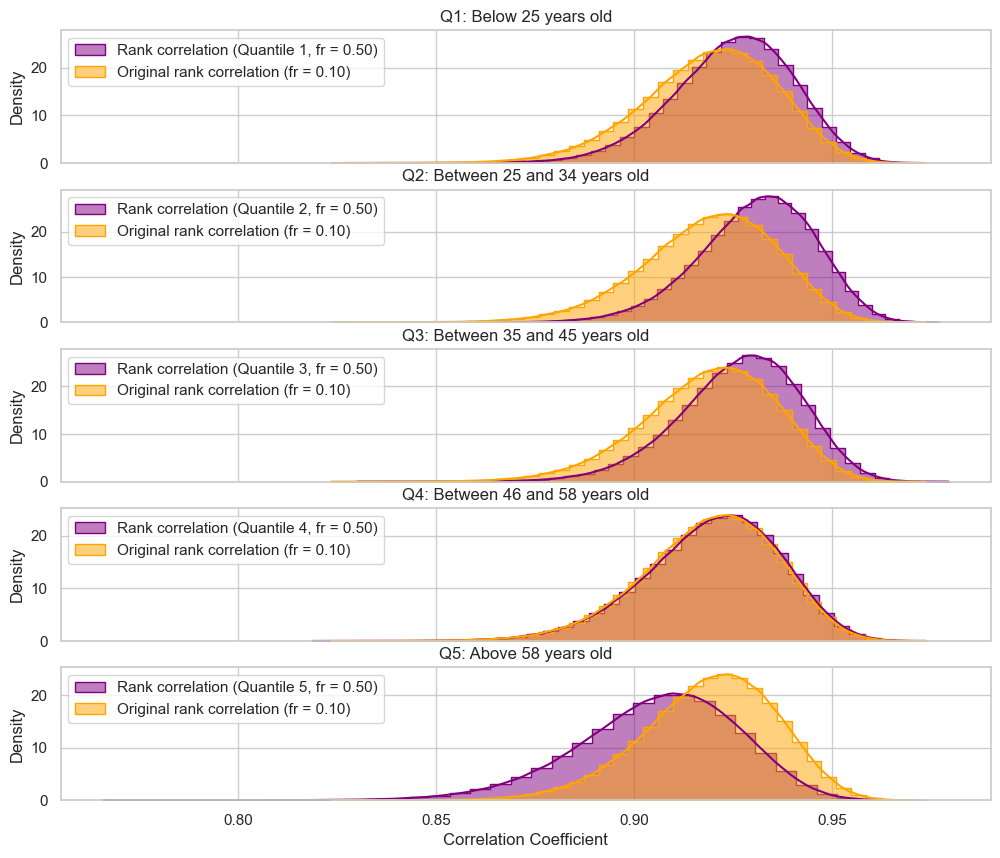

In [9]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

sns.histplot(rank_correlations['Q1'], bins=40, color='purple', kde=True, label='Rank correlation (Quantile 1, fr = 0.50)', element='step', stat='density', ax=axes[0])
sns.histplot(df_population_random_sampling_spearman['spearman'], bins=40, color='orange', kde=True, label='Original rank correlation (fr = 0.10)', element='step', stat='density', ax=axes[0])
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Patience: Rank Correlation for each Quantile Group')

axes[0].set_ylabel('Density')
axes[0].set_title('Q1: Below 25 years old')
axes[0].legend()



sns.histplot(rank_correlations['Q2'], bins=40, color='purple', kde=True, label='Rank correlation (Quantile 2, fr = 0.50)', element='step', stat='density', ax=axes[1])
sns.histplot(df_population_random_sampling_spearman['spearman'], bins=40, color='orange', kde=True, label='Original rank correlation (fr = 0.10)', element='step', stat='density', ax=axes[1])
axes[1].set_ylabel('Density')
axes[1].set_title('Q2: Between 25 and 34 years old')
axes[1].legend()



sns.histplot(rank_correlations['Q3'], bins=40, color='purple', kde=True, label='Rank correlation (Quantile 3, fr = 0.50)', element='step', stat='density', ax=axes[2])
sns.histplot(df_population_random_sampling_spearman['spearman'], bins=40, color='orange', kde=True, label='Original rank correlation (fr = 0.10)', element='step', stat='density', ax=axes[2])
axes[2].set_ylabel('Density')
axes[2].set_title('Q3: Between 35 and 45 years old')
axes[2].set_xlabel('Correlation Coefficient')
axes[2].legend()


sns.histplot(rank_correlations['Q4'], bins=40, color='purple', kde=True, label='Rank correlation (Quantile 4, fr = 0.50)', element='step', stat='density', ax=axes[3])
sns.histplot(df_population_random_sampling_spearman['spearman'], bins=40, color='orange', kde=True, label='Original rank correlation (fr = 0.10)', element='step', stat='density', ax=axes[3])
axes[3].set_ylabel('Density')
axes[3].set_title('Q4: Between 46 and 58 years old')
axes[3].set_xlabel('Correlation Coefficient')
axes[3].legend()


sns.histplot(rank_correlations['Q5'], bins=40, color='purple', kde=True, label='Rank correlation (Quantile 5, fr = 0.50)', element='step', stat='density', ax=axes[4])
sns.histplot(df_population_random_sampling_spearman['spearman'], bins=40, color='orange', kde=True, label='Original rank correlation (fr = 0.10)', element='step', stat='density', ax=axes[4])
axes[4].set_ylabel('Density')
axes[4].set_title('Q5: Above 58 years old')
axes[4].set_xlabel('Correlation Coefficient')
axes[4].legend()

plt.show()
#save in plots folder
#plt.savefig(r'C:\Users\Mumu\Desktop\Bonn Econ\RM_applied_micro\GIthub_new\rm-applied-micro\plots\quantile_disribution_patience.png')